In [ ]:
import numpy as np
import random
from scipy.stats import norm
import math
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
class K_arm_bandit:
  def __init__ (self,p_k,myu_k=None):
    self.p_k=p_k #腕ごとの報酬確率の列
    self.myu_k=myu_k #腕ごとの報酬平均、発展課題2に必要

  def return_reward(self,action): #ベルヌーイ分布
    if random.random()<=self.p_k[action]:
      return 1.0 
    else:
      return 0.0
  
  def return_reward_normal(self,action): #正規分布
    return np.random.normal(loc=self.myu_k[action],scale=1)


In [ ]:
class Agent:
  def __init__(self,arm_myu,arm_times):
    self.arm_myu=arm_myu #腕の平均値
    self.arm_times=arm_times #腕の選択回数
  
  def initialize(self,arm_size):
    self.arm_myu = np.zeros(arm_size)
    self.arm_times = np.ones(arm_size) #腕の選択回数。0割の処理が面倒なので1回引いた状態で始めることにした。
  
  def update(self,reward,action): #平均の更新
    self.arm_myu[action] = self.arm_myu[action]+(1/self.arm_times[action])*(reward-self.arm_myu[action])

In [ ]:
class Epsilon_greedy:
  def __init__(self,epsilon=0.1):
    self.epsilon=epsilon

  def select_arm(self,value):
    if random.random()<self.epsilon:
      return random.randint(0,len(value)-1)
    else:
      maxIndex = [i for i, x in enumerate(value) if x == np.max(value)] #argmaxの先頭対策
      return random.choice(maxIndex) 


In [ ]:
class Softmax:
  def __init__(self,beta=1):
    self.beta=beta

  def select_arm(self,value):
    x = np.exp(value*self.beta)
    u = np.sum(x)
    return np.random.choice(len(x),p=x/u) 


In [ ]:
class UCB:
  def __init__(self,c=1):
    self.c = c

  def select_arm(self,mean_value,step,arm_times):
    ucb1 = mean_value + self.c*np.sqrt(np.log(step)/arm_times)
    print(ucb1)
    maxIndex = [i for i, x in enumerate(ucb1) if x == np.max(ucb1)]
    return np.max(maxIndex)


In [ ]:
#実験設定（当然classなどにしても◯）
n_sim = 100
steps = 1000
e=0.1
p=[0.3,0.5,0.7]
arm_size = len(p)

#環境とエージェント、方策
env = K_arm_bandit(p)
agent = Agent(np.zeros(arm_size),np.ones(arm_size)) 

#方策選択
#pi = UCB()  
#pi = Softmax()
pi = Epsilon_greedy()

#評価指標
regret = np.zeros((n_sim,steps))

##################################################

#main
for sim in range(n_sim):
  for step in range(1,steps):
    #action = pi.select_arm(agent.arm_myu,step,agent.arm_times) #UCBの時はこちらで行動選択
    action = pi.select_arm(agent.arm_myu)
    agent.arm_times[action] += 1
    reward = env.return_reward(action)
    agent.update(reward,action)
    regret[sim,step] += regret[sim,step-1]+np.max(p)-p[action]
  agent.initialize(arm_size)

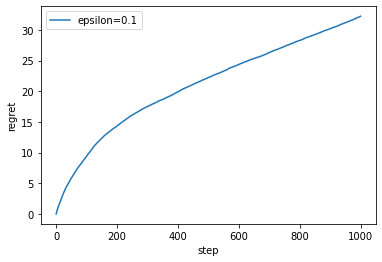

In [ ]:
plt.xlabel("step")
plt.ylabel("regret") 
plt.plot(np.mean(regret,axis=0),label="epsilon=0.1")
plt.legend(loc="best")

##発展課題2

In [ ]:
n_sim = 2000
steps = 1000
e=[0,0.1,0.01]
arm_myu=np.random.normal(loc=0,scale=1,size=10)
arm_size = len(arm_myu)
env = K_arm_bandit(arm_size,arm_myu)
agent = Agent(np.zeros(arm_size),np.zeros(arm_size))
pi = Epsilon_greedy(e)

average_reward=np.zeros((n_sim,steps,len(e)))
best_choice=np.zeros((n_sim,steps,len(e)))

for eps in range(len(e)):
  pi = Epsilon_greedy(e[eps])
  for sim in range(n_sim):
    for step in range(steps):
      action = pi.select_arm(agent.arm_myu)
      agent.arm_times[action] += 1
      reward = env.return_reward_normal(action)
      agent.update(reward,action)
      average_reward[sim,step,eps] += reward
      if action==np.argmax(arm_myu):
        best_choice[sim,step,eps]=1
    agent.initialize(arm_size)

In [ ]:
mean_reward=np.mean(average_reward,axis=0)
mean_reward.shape

(1000, 3)

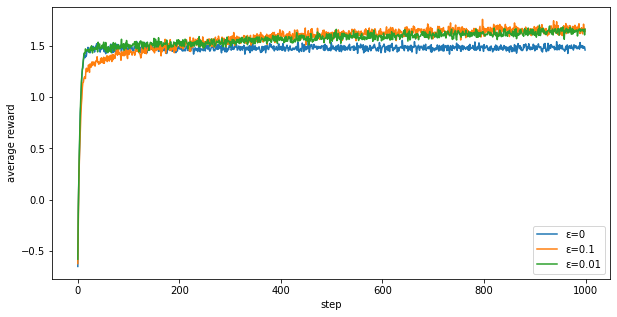

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel("step")
plt.ylabel("average reward") 
for i in range(len(mean_reward[1])):
  plt.plot(mean_reward[:,i],label="ε="f"{e[i]}")
plt.legend(loc="best")

In [ ]:
best=np.mean(best_choice,axis=0)

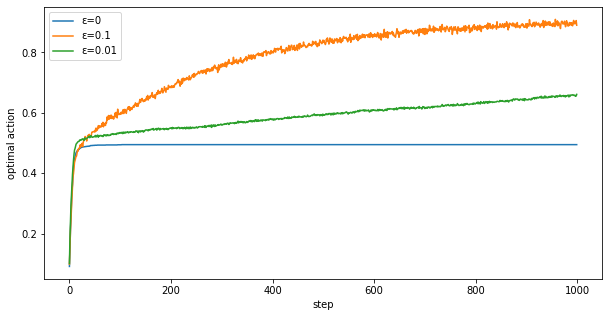

In [ ]:
plt.figure(figsize=(10,5))
plt.xlabel("step")
plt.ylabel("optimal action") 
for i in range(len(mean_reward[1])):
  plt.plot(best[:,i],label="ε="f"{e[i]}")
plt.legend(loc="best")

#おまけ

In [ ]:
#arm_data=[(np.random.normal(loc=arm_myu[i],scale=1,size=1000))  for i in range(arm_myu)]
arm_data = np.array([])
for i in range(len(arm_myu)):
  arm_data=np.append(arm_data,np.random.normal(loc=arm_myu[i],scale=1,size=10000))

In [ ]:
arm_data=arm_data.reshape(10,10000)
arm_data.shape,arm_myu

((10, 10000),
 array([-0.5432021 ,  1.21191126,  1.92083698, -1.45493794, -0.96697218,
        -1.69658576,  0.17133897, -2.50791409, -1.49154354, -0.77051229]))

In [ ]:
np.mean(arm_data,axis=1)

array([-0.52641378,  1.22297924,  1.9194067 , -1.4491058 , -0.95726271,
       -1.70187793,  0.16358873, -2.50463248, -1.50101683, -0.75860029])

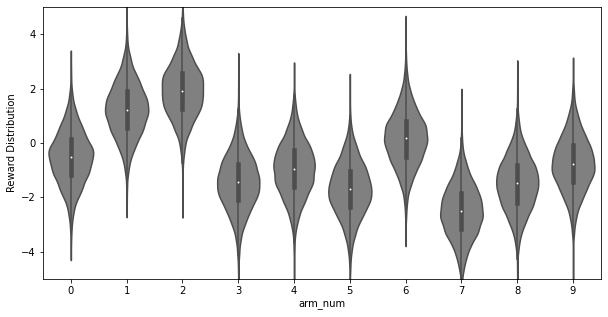

In [ ]:
fig = plt.figure(figsize=(10,5))
ax=fig.add_subplot(1,1,1)
sns.violinplot( data=arm_data.T,color='gray',showmeans=True)
ax.set_xlabel('arm_num')
ax.set_ylabel('Reward Distribution')
ax.set_ylim(-5, 5)
plt.show()